In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, RocCurveDisplay
from libcharlotte import process_data, transform_labels, get_start_dates
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from quantstats.reports import full
from tqdm.auto import tqdm

In [2]:
# read in dataframe
df = pd.read_csv("merged_data.csv", index_col='Date', parse_dates=['Date'])
new_idx = pd.date_range(min(df.index), max(df.index), freq='D')
df = df.reindex(new_idx)
cols = list(df.columns)

cols.remove("crude_net")
cols.remove("products_net")
cols.remove("gas_supplied")

cols
mindex, maxdex, df_proc = process_data(df, cols, 20, [20*i for i in range(7)], "1990-01-01", "2019-12-31")
# set the targets
days_forecast = 15

crack_reindex = df.crack.reindex_like(df_proc)
crack_targets = (crack_reindex.shift(-days_forecast)/crack_reindex - 1)[:-days_forecast]
crack_targets = crack_targets.fillna(method = 'ffill')

## Create XGBoost Model

In [31]:
model = XGBRegressor(objective = 'binary:logistic', eval_metric='auc')

days_forecast = 20
X = df_proc[:-days_forecast]

crack_reindex = df.crack.reindex_like(df_proc)
crack_targets = (crack_reindex.shift(-days_forecast)/crack_reindex - 1)[:-days_forecast]
crack_targets = crack_targets.fillna(method = 'ffill')
crack_targets = crack_targets.reindex_like(X)

cutoff_value, y = transform_labels(crack_targets, 15, higher=False)
print(cutoff_value)

cutoff_date = datetime(2012, 1, 1).date()

X_train = X[X.index <= cutoff_date]
X_test = X[X.index > cutoff_date]

y_train = y[y.index <= cutoff_date]
y_test = y[y.index > cutoff_date]

model.fit(X_train, y_train)

-0.35902961885683266


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='binary:logistic', predictor='auto',
             random_state=0, reg_alpha=0, ...)

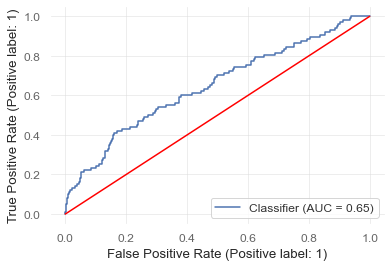

In [32]:
s = np.linspace(0, 1, 100)
y_hat = model.predict(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_hat)
roc_curve_plot = RocCurveDisplay.from_predictions(y_test, y_hat)
plt.plot(s, s, color = 'red')
plt.show()

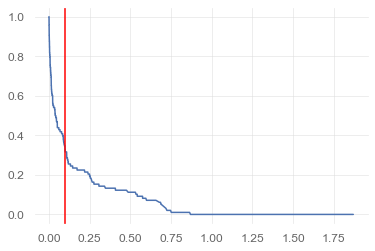

In [34]:
plt.plot(threshold, tpr)
plt.axvline(x = 0.1, color = 'red')
plt.show()

## Trading Model

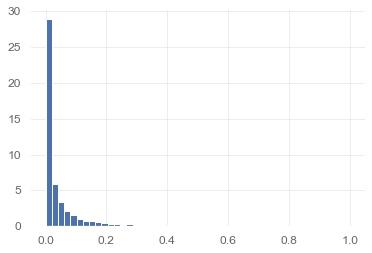

In [35]:
plt.hist(y_hat, bins=np.linspace(0, 1, 50), density=True)
plt.show()

In [36]:
target_threshold = 0.1

trade_decisions = pd.Series(y_hat, name="position")
trade_decisions.index = X_test.index
trade_decisions = trade_decisions.apply(lambda x: int(x >= target_threshold))

trade_decisions.head()

2012-01-03    0
2012-01-04    0
2012-01-05    0
2012-01-06    0
2012-01-09    0
Name: position, dtype: int64

In [37]:
trade_decisions.describe()

count    1992.000000
mean        0.149598
std         0.356767
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: position, dtype: float64

In [38]:
crack_returns = df.crack.reindex_like(trade_decisions)
crack_returns = (crack_returns.shift(-1)/crack_returns - 1).dropna()
crack_returns

2012-01-03    0.044530
2012-01-04   -0.076080
2012-01-05    0.118249
2012-01-06   -0.002919
2012-01-09   -0.000399
                ...   
2019-11-22   -0.015623
2019-11-25   -0.005514
2019-11-26   -0.062213
2019-11-27    0.000000
2019-11-29   -0.150851
Name: crack, Length: 1975, dtype: float64

In [42]:
trade_decisions2 = trade_decisions.reindex_like(crack_returns)
trade_returns = trade_decisions2*crack_returns
trade_returns.index = pd.DatetimeIndex(trade_returns.index)

In [43]:
trade_returns.head()

2012-01-03    0.0
2012-01-04   -0.0
2012-01-05    0.0
2012-01-06   -0.0
2012-01-09   -0.0
dtype: float64

In [44]:
trade_returns.describe()

count    1975.000000
mean       -0.000147
std         0.033598
min        -0.372248
25%         0.000000
50%         0.000000
75%         0.000000
max         0.490811
dtype: float64

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2012-01-03  2012-01-03
End Period                 2019-11-29  2019-11-29
Risk-Free Rate             0.0%        0.0%
Time in Market             15.0%       100.0%

Cumulative Return          -75.15%     187.81%
CAGR﹪                     -16.14%     14.3%

Sharpe                     -0.07       1.13
Prob. Sharpe Ratio         42.34%      99.9%
Smart Sharpe               -0.06       1.04
Sortino                    -0.1        1.59
Smart Sortino              -0.1        1.46
Sortino/√2                 -0.07       1.12
Smart Sortino/√2           -0.07       1.03
Omega                      0.97        0.97

Max Drawdown               -85.43%     -15.95%
Longest DD Days            2618        272
Volatility (ann.)          53.34%      12.68%
R^2                        0.0         0.0
Information Ratio          -0.02       -0.02
Calmar                     -0.19       

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2012-09-28  2019-10-29  2019-11-29  2618    -85.425342        -85.218793
2  2012-06-25  2012-07-24  2012-09-07    74    -39.320065        -39.012620
3  2012-09-11  2012-09-17  2012-09-25    14    -27.241174        -25.634512
4  2012-06-15  2012-06-20  2012-06-22     7    -11.194725         -8.892687
5  2012-01-13  2012-01-13  2012-01-17     4     -5.623527          0.000000

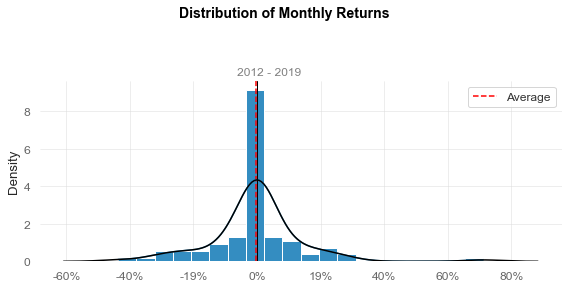

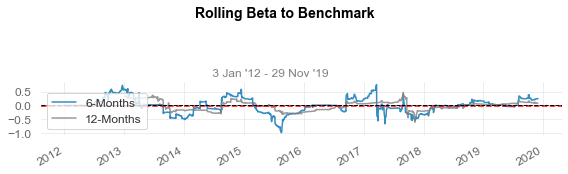

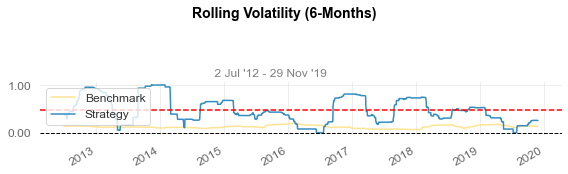

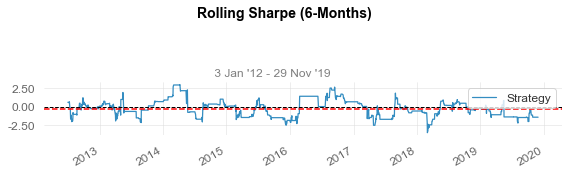

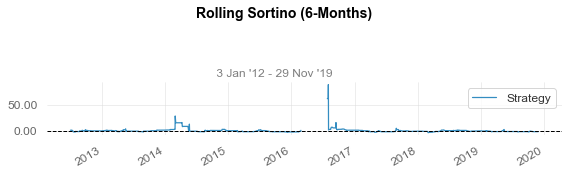

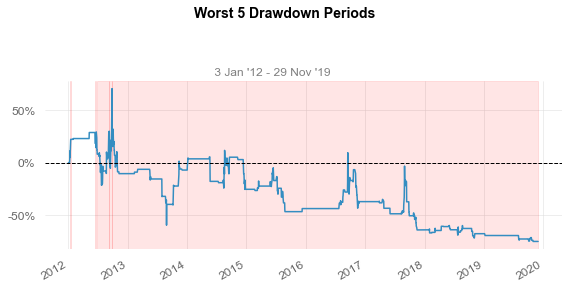

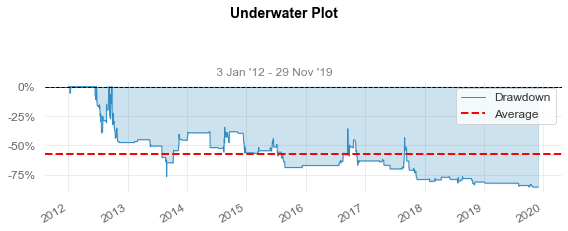

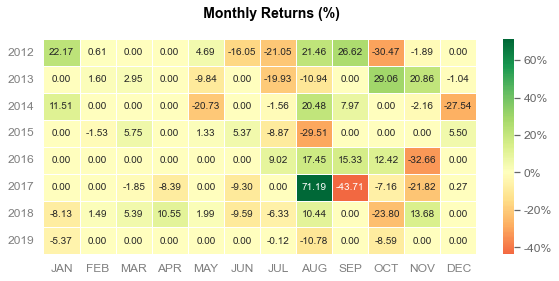

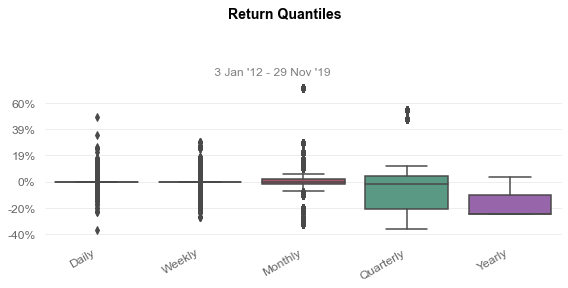

In [45]:
full(trade_returns, 'SPY')